In [2]:
import sys
from pprint import pprint
from pathlib import Path
import pickle

import numpy as np
import torch

import matplotlib.pyplot as plt
plt.style.use('dark_background')

np.random.seed(45)
torch.random.manual_seed(45)



In [3]:
def theta_distributions(theta, verbose=False, ncols = 4, n_bins = 50, hrange=None, hcolor=None ):
    """ plot histograms of each dimension found on each row in <theta>,
    e.g. theta.shape = (64,4), this would give 4 histograms where each of the
    four dimensions in theta.shape[-1] will be plotted

    Returns
    -------
    fig : matplotlib.figure
          the matplotlib sublpots figure object
    axs : matplotlib.axes object
          the matplotlib sublpots axes object
    """

    nparams = theta.shape[-1]
    nrows = round((nparams + ncols - 1)/ncols)
    print(f"preparing {nrows}x{ncols} figure")
    fig, axs = plt.subplots(nrows, ncols, figsize=(16, 12), sharey=True, tight_layout=True)

    print("{0:>5s} {1:>8s} {2:>8s} {3:>8s} {4:>8s}".format("index","min","mean","std","max"))

    for yax in range(nrows):
        for xax in range(ncols):
            idx = yax*ncols + xax
            if idx >= theta.shape[-1]:
                axs[yax, xax].axis('off')
                continue
            var = theta[:, idx]

            payload = (idx, theta.shape[-1], var.min(), var.mean(), var.std(), var.max())
            print("{0:2.0f}/{1:2.0f} {2:>8.4f} {3:>8.4f} {4:>8.4f} {5:>8.4f}".format(*payload))

            axs[yax, xax].hist(var, bins=n_bins, range=hrange,  color=hcolor)
            axs[yax, xax].set_title(f"param {idx}/{theta.shape[-1]}\nmean: {var.mean():8.4f}, std: {var.std():8.4f}, N: {var.size}")

    return fig, axs

In [4]:
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

## Model Calibration with Simulation-Based Calibration (SBC)

- inspired by Talts et al "Validating Bayesian Inference Algorithms with Simulation-Based Calibration" http://arxiv.org/abs/1804.06788
- see also this repo implemting SBC with pyMC3 https://github.com/ColCarroll/simulation_based_calibration


In [5]:

def sbc_ranks(prior, posterior, simulate_fn, n_trials = 1024, n_draws = 8192):
    """
    Under BSD-3 license by Peter Steinbach, 2021

    implemting rank statistic simulation-based calibration given a SBI trained posterior
    introducted by Talts et al "Validating Bayesian Inference Algorithms with
    Simulation-Based Calibration" http://arxiv.org/abs/1804.06788

    (TODO: unclear if the function f on page 5, just below equation 2 is coded
    correctly)

    Parameters
    ----------
    prior : sbi.prior
            prior object as returned by torch.distributions.MultivariateNormal or sbi.utils.BoxUniform
    posterior : sbi.posterior object
                posterior object as returned by inference.build_posterior
    simulate_fn : function object
                  expected to take one single argument <theta> to produce samples of <x>
    n_trials : int, default=1024
               number of times to sample the posterior
    n_draws : int, default=8192
              number of samples to draw per trial

    Returns
    -------
    nranks : np.ndarray
             returns an ndarray of shape=(n_trials, theta.shape[-1]);
             for each batch, the rank of the estimated theta dimension is contained
             with respect to the expectation drawn from the prior
    """
    exp_theta = prior.sample((n_trials,))
    nranks = np.zeros((n_trials, exp_theta.shape[-1]))

    #TODO: this can be parallelized
    for idx in range(n_trials):
        x_o = simulate_fn(exp_theta[idx])

        #draw samples from model
        posterior_samples = posterior.sample((ndraws,),
                                             x=x_o,
                                             show_progress_bars=False).detach().numpy()

        #expand single theta_tilde to match posterior_samples.shape
        out_shape = (ndraws, exp_theta.shape[-1])
        x_tilde_tiled = np.tile(exp_theta[idx], ndraws).reshape(out_shape)

        #compute mask as described on page 5 just below equation 2
        mask = posterior_samples < x_tilde_tiled

        #sum up mask to provide ranks per dimension
        nranks[idx, ...] = mask.sum(axis=0)

    return nranks


In [6]:
#taken from https://www.mackelab.org/sbi/tutorial/02_flexible_interface/#linear-gaussian-example

num_dim = 3
prior = utils.BoxUniform(low=-2*torch.ones(num_dim), 
                         high=2*torch.ones(num_dim))

def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

simulator, prior = prepare_for_sbi(linear_gaussian, prior)
inference = SNPE(prior=prior)
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=500)
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Neural network successfully converged after 133 epochs.


In [7]:
posterior = inference.build_posterior(density_estimator)
print(posterior)

Posterior conditional density p(θ|x) (amortized).

This DirectPosterior-object was obtained with a SNPE-class method using a flow.
It allows to .sample() and .log_prob() the posterior and wraps the output of the .net to avoid leakage into regions with 0 prior probability.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

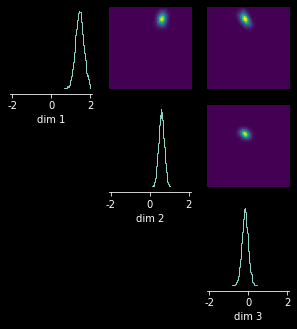

In [8]:
exp_theta = prior.sample((128,))
x_o = linear_gaussian(exp_theta)
posterior_samples = posterior.sample((10000,), x=x_o[0, ...])

# plot posterior samples
_ = analysis.pairplot(posterior_samples, limits=[[-2.1,2.1],[-2.1,2.1],[-2.1,2.1]], 
                   figsize=(5,5))

In [9]:
n_trials = 1024
n_draws = 8*1024

# exp_theta = prior.sample((n_trials,))
# x_o = linear_gaussian(exp_theta)

nranks = sbc_ranks(prior, posterior, linear_gaussian, n_trials, n_draws)


preparing 2x2 figure
index      min     mean      std      max
 0/ 3 109.0000 3924.5234 1833.7573 8047.0000
 1/ 3   7.0000 4135.5283 1841.8389 8140.0000
 2/ 3  21.0000 4018.1514 2003.0869 8147.0000


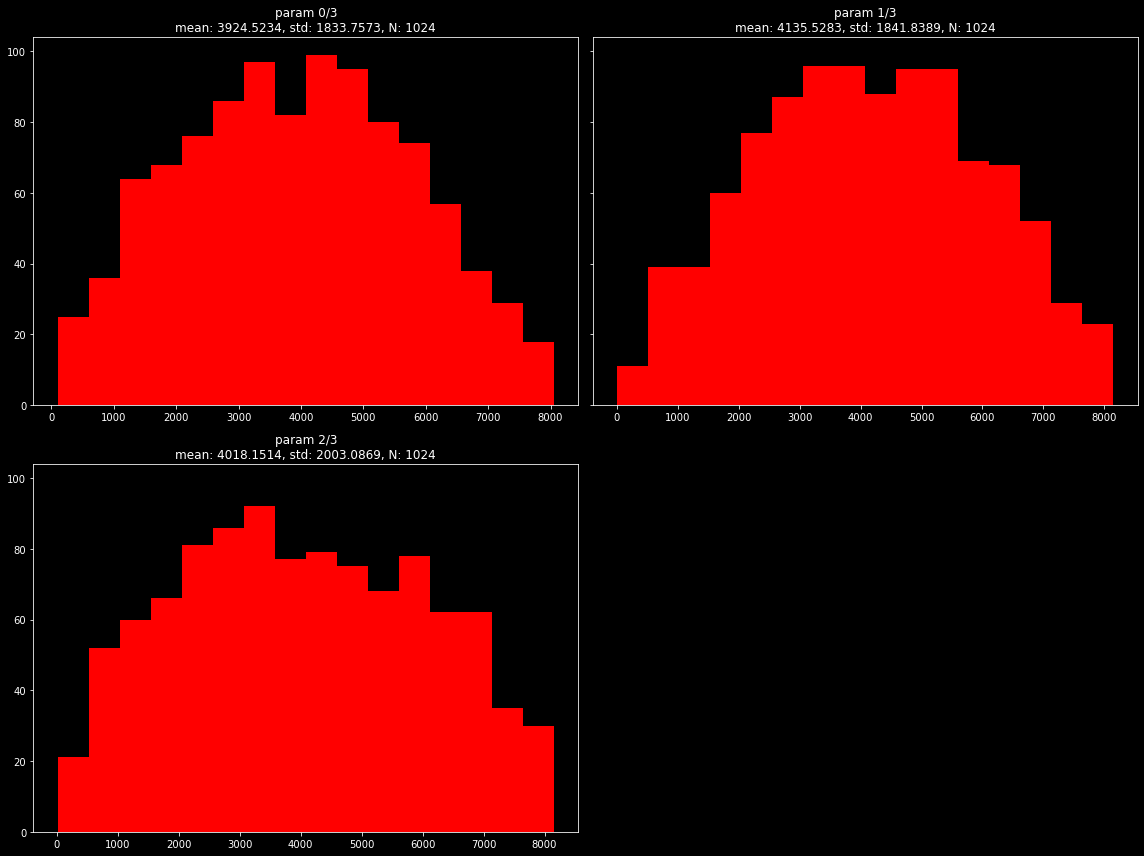

In [10]:
f, axs = theta_distributions(nranks, ncols =2, n_bins = 16, hcolor='r' )
f.savefig("sbi_linear_gaussian_dataset_3p_sbc_ranks.svg")

The above should match figure 5b on page 7 of [Talts et al](http://arxiv.org/abs/1804.06788).

In [11]:
#let's try again and increase the number of training runs for SBI by 30x

theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=15000)
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()


Running 15000 simulations.:   0%|          | 0/15000 [00:00<?, ?it/s]

Neural network successfully converged after 143 epochs.


In [12]:
posterior = inference.build_posterior(density_estimator)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

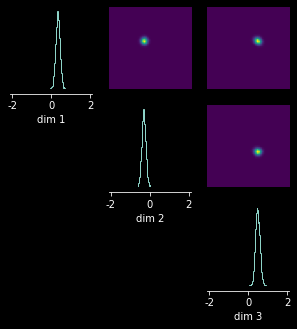

In [13]:
exp_theta = prior.sample((128,))
x_o = linear_gaussian(exp_theta)
posterior_samples = posterior.sample((10000,), x=x_o[0, ...])

# plot posterior samples
_ = analysis.pairplot(posterior_samples, limits=[[-2.1,2.1],[-2.1,2.1],[-2.1,2.1]], 
                   figsize=(5,5))

In [14]:
# n_trials = 1024
# n_draws = 8*1024

nranks = sbc_ranks(prior, posterior, linear_gaussian, n_trials, n_draws)

preparing 2x2 figure
index      min     mean      std      max
 0/ 3   1.0000 4238.2637 2317.2850 8190.0000
 1/ 3  13.0000 3987.5762 2257.0593 8181.0000
 2/ 3   7.0000 3937.0000 2409.5840 8191.0000


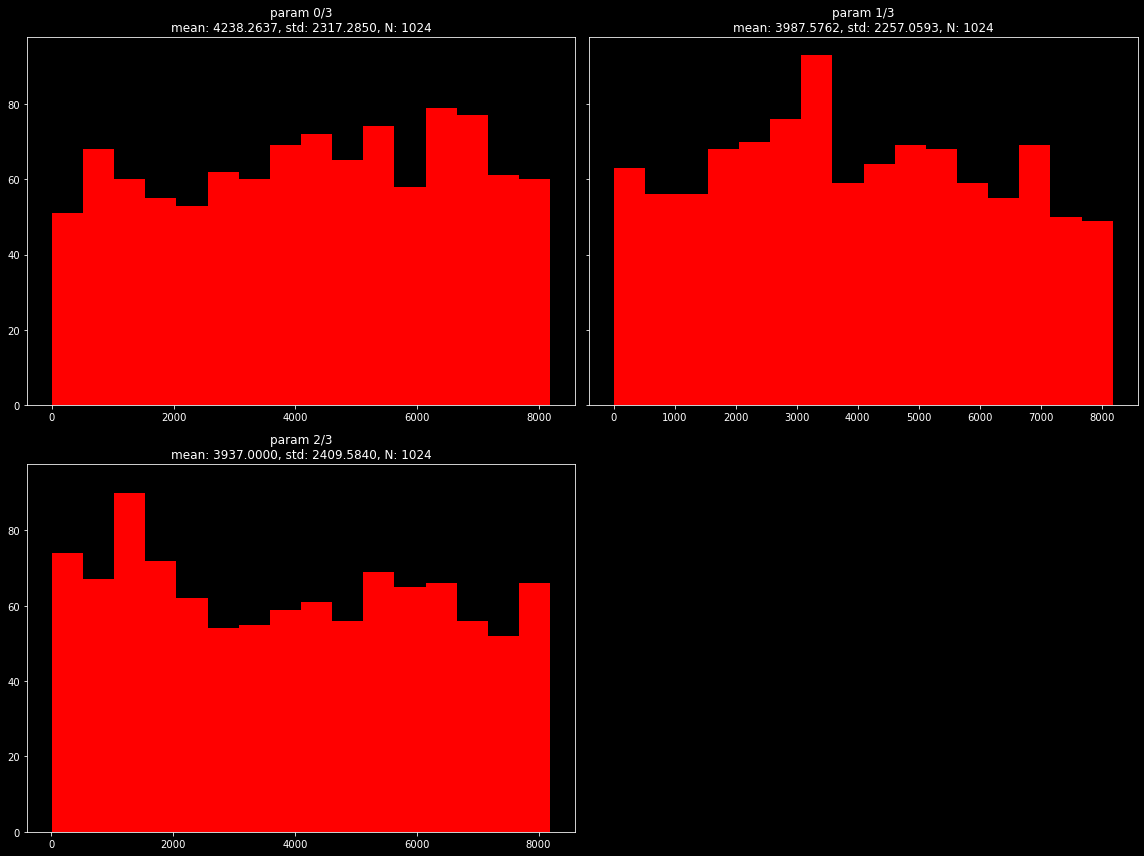

In [15]:
f, axs = theta_distributions(nranks, ncols =2, n_bins = 16, hcolor='r' )
f.savefig("sbi_linear_gaussian_dataset_3p_sbc_ranks_15ksamples.svg")